In [28]:
import sys
import time
import uuid
import random
from uuid7gen import uuid7

#### Checking Python Verion

In [2]:
print(sys.version)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]


#### Creating a UUID with UUID7

In [29]:
print(uuid7())

0197ebed-b0d1-7ed3-ab36-e89c4f005f88


#### Creating a UUID with UUID4

In [4]:
print(uuid.uuid4())

71755ca0-c7d7-4370-b2c9-451a59cd3a9f


#### Comparing sort times

In [11]:
NUM_UUIDS = 10_000_000  # Number of UUIDs to generate

# Generate UUIDs
uuids_v4 = [uuid.uuid4() for _ in range(NUM_UUIDS)]
uuids_v7 = [uuid7() for _ in range(NUM_UUIDS)]

# Shuffle both to simulate realistic usage
random.shuffle(uuids_v4)
random.shuffle(uuids_v7)

# Benchmark sort time
def benchmark_sort(label, data):
    start = time.perf_counter()
    sorted_data = sorted(data)
    end = time.perf_counter()
    print(f"{label:<10} sort time: {end - start:.4f} seconds")
    return sorted_data

sorted_v4 = benchmark_sort("UUIDv4", uuids_v4)
sorted_v7 = benchmark_sort("UUIDv7", uuids_v7)

UUIDv4     sort time: 91.2755 seconds
UUIDv7     sort time: 97.3224 seconds


In [ ]:
import time
import uuid
import random
import matplotlib.pyplot as plt
from uuid7gen import uuid7


def simulate_timestamp_spread(n, spread_ms):
    """
    Simulates computational overhead by generating fake timestamps.
    Returns a list of millisecond timestamps (not used in UUIDs).
    """
    base_time = time.time()
    return [base_time + random.randint(0, spread_ms) / 1000 for _ in range(n)]


def generate_uuid4_batch(n, spread_ms=100):
    simulate_timestamp_spread(n, spread_ms)  # equal overhead
    return [uuid.uuid4() for _ in range(n)]


def generate_uuid7_batch(n, spread_ms=100):
    simulate_timestamp_spread(n, spread_ms)  # equal overhead
    return [uuid7() for _ in range(n)]


def benchmark(func, *args, label="", **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    duration = end - start
    print(f"{label:<35} took {duration:.4f} seconds")
    return result, duration


def run_benchmark(n=1_000_000, spread_ms=200):
    print(f"\nBenchmarking UUID performance for {n:,} entries\n")
    print(f"(Simulated timestamp spread: {spread_ms} ms)\n")

    # Generate UUIDs with matched computational overhead
    uuids_v4, gen_time_v4 = benchmark(generate_uuid4_batch, n, spread_ms, label="Generate UUIDv4")
    uuids_v7, gen_time_v7 = benchmark(generate_uuid7_batch, n, spread_ms, label="Generate UUIDv7")

    # Shuffle before sorting
    random.shuffle(uuids_v4)
    random.shuffle(uuids_v7)

    # Sort using bytes
    _, sort_time_v4 = benchmark(sorted, uuids_v4, key=lambda u: u.bytes, label="Sort UUIDv4 (by bytes)")
    _, sort_time_v7 = benchmark(sorted, uuids_v7, key=lambda u: u.bytes, label="Sort UUIDv7 (by bytes)")

    # Report
    print("\nSummary:")
    print(f"UUIDv4 - Generation: {gen_time_v4:.3f}s | Sorting: {sort_time_v4:.3f}s")
    print(f"UUIDv7 - Generation: {gen_time_v7:.3f}s | Sorting: {sort_time_v7:.3f}s")
    print(f"UUIDv7 Generation Speedup: {(gen_time_v4 - gen_time_v7) / gen_time_v4:.1%}")
    print(f"UUIDv7 Sort Speedup:        {(sort_time_v4 - sort_time_v7) / sort_time_v4:.1%}")

    return {
        "count": n,
        "gen_v4": gen_time_v4,
        "gen_v7": gen_time_v7,
        "sort_v4": sort_time_v4,
        "sort_v7": sort_time_v7
    }


if __name__ == "__main__":
    run_benchmark(n=2_000_000, spread_ms=200)


Benchmarking UUID performance for 1,000,000 entries

(Simulated timestamp spread: 200 ms)

Generate UUIDv4                     took 4.3300 seconds
Generate UUIDv7                     took 4.7699 seconds
Sort UUIDv4 (by bytes)              took 1.4062 seconds
Sort UUIDv7 (by bytes)              took 1.5383 seconds

Summary:
UUIDv4 - Generation: 4.330s | Sorting: 1.406s
UUIDv7 - Generation: 4.770s | Sorting: 1.538s
UUIDv7 Generation Speedup: -10.2%
UUIDv7 Sort Speedup:        -9.4%


In [21]:
import time
import uuid
import random
import gc
import statistics
import csv
from uuid7gen import uuid7


def simulate_timestamp_spread(n, spread_ms):
    """
    Simulates computational overhead: generates fake timestamps.
    """
    base_time = time.time()
    return [base_time + random.randint(0, spread_ms) / 1000 for _ in range(n)]


def generate_uuid4_batch(n, spread_ms=100):
    simulate_timestamp_spread(n, spread_ms)
    return [uuid.uuid4() for _ in range(n)]


def generate_uuid7_batch(n, spread_ms=100):
    simulate_timestamp_spread(n, spread_ms)
    return [uuid7() for _ in range(n)]


def benchmark(func, *args, **kwargs):
    """
    Returns the result and duration (in seconds).
    """
    label = kwargs.pop("label", "")
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    duration = end - start
    if label:
        print(f"{label:<35} took {duration:.4f} seconds")
    return result, duration


def median_benchmark(func, *args, runs=5, **kwargs):
    """
    Runs a benchmark function multiple times and returns median duration.
    """
    label = kwargs.get("label", "")
    durations = []

    for i in range(runs):
        gc.collect()
        gc.disable()
        _, dur = benchmark(func, *args, **kwargs)
        gc.enable()
        durations.append(dur)

    median_time = statistics.median(durations)
    print(f"Median of {runs} runs for {label:<20}: {median_time:.4f} sec\n")
    return median_time


def run_benchmark(n=1_000_000, spread_ms=200, runs=5, export_csv=False):
    print(f"\nBenchmarking UUIDv4 vs UUIDv7 with {n:,} IDs\n")
    print(f"(Each test uses fixed seed, {runs} runs, spread_ms={spread_ms})\n")

    random.seed(42)

    # Warmup
    generate_uuid4_batch(10_000)
    generate_uuid7_batch(10_000)

    # UUIDv4 generation and sort
    gen_time_v4 = median_benchmark(generate_uuid4_batch, n, spread_ms, runs=runs, label="Generate UUIDv4")
    uuid4s = generate_uuid4_batch(n, spread_ms)
    # random.shuffle(uuid4s)
    sort_time_v4 = median_benchmark(sorted, uuid4s, key=lambda u: u.bytes, runs=runs, label="Sort UUIDv4 (by bytes)")

    # UUIDv7 generation and sort
    gen_time_v7 = median_benchmark(generate_uuid7_batch, n, spread_ms, runs=runs, label="Generate UUIDv7")
    uuid7s = generate_uuid7_batch(n, spread_ms)
    # random.shuffle(uuid7s)
    sort_time_v7 = median_benchmark(sorted, uuid7s, key=lambda u: u.bytes, runs=runs, label="Sort UUIDv7 (by bytes)")

    print("Summary (median of runs):")
    print(f"UUIDv4 - Generate: {gen_time_v4:.3f}s | Sort: {sort_time_v4:.3f}s")
    print(f"UUIDv7 - Generate: {gen_time_v7:.3f}s | Sort: {sort_time_v7:.3f}s")
    print(f"UUIDv7 Generation Speedup: {(gen_time_v4 - gen_time_v7) / gen_time_v4:.1%}")
    print(f"UUIDv7 Sort Speedup:        {(sort_time_v4 - sort_time_v7) / sort_time_v4:.1%}")

    if export_csv:
        with open("uuid_benchmark_results.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["Metric", "UUIDv4 (s)", "UUIDv7 (s)", "Speedup (%)"])
            writer.writerow(["Generation", gen_time_v4, gen_time_v7, (gen_time_v4 - gen_time_v7) / gen_time_v4 * 100])
            writer.writerow(["Sorting", sort_time_v4, sort_time_v7, (sort_time_v4 - sort_time_v7) / sort_time_v4 * 100])
        print("\nResults written to uuid_benchmark_results.csv")

    return {
        "count": n,
        "gen_v4": gen_time_v4,
        "gen_v7": gen_time_v7,
        "sort_v4": sort_time_v4,
        "sort_v7": sort_time_v7
    }


if __name__ == "__main__":
    run_benchmark(
        n=100_000,     # adjust to 10_000_000 if your system has enough memory
        spread_ms=200,   # simulates realistic timestamp spacing
        runs=5,          # runs per test for median calculation
        export_csv=True  # saves results to CSV
    )



Benchmarking UUIDv4 vs UUIDv7 with 100,000 IDs

(Each test uses fixed seed, 5 runs, spread_ms=200)

Generate UUIDv4                     took 0.4527 seconds
Generate UUIDv4                     took 0.3914 seconds
Generate UUIDv4                     took 0.3791 seconds
Generate UUIDv4                     took 0.3954 seconds
Generate UUIDv4                     took 0.3831 seconds
Median of 5 runs for Generate UUIDv4     : 0.3914 sec

Sort UUIDv4 (by bytes)              took 0.0853 seconds
Sort UUIDv4 (by bytes)              took 0.0845 seconds
Sort UUIDv4 (by bytes)              took 0.0854 seconds
Sort UUIDv4 (by bytes)              took 0.0793 seconds
Sort UUIDv4 (by bytes)              took 0.1130 seconds
Median of 5 runs for Sort UUIDv4 (by bytes): 0.0853 sec

Generate UUIDv7                     took 0.4478 seconds
Generate UUIDv7                     took 0.4560 seconds
Generate UUIDv7                     took 0.4746 seconds
Generate UUIDv7                     took 0.4550 seconds
Gen


Benchmarking UUIDv4 vs UUIDv7 with 1,000,000 IDs (no shuffle)

Generate UUIDv4                     took 4.4665 seconds
Generate UUIDv4                     took 3.8778 seconds
Generate UUIDv4                     took 3.7653 seconds
Generate UUIDv4                     took 3.2709 seconds
Generate UUIDv4                     took 3.3603 seconds
Median of 5 runs for Generate UUIDv4     : 3.7653 sec

Sort UUIDv4 (by bytes)              took 1.0510 seconds
Sort UUIDv4 (by bytes)              took 1.0618 seconds
Sort UUIDv4 (by bytes)              took 1.0363 seconds
Sort UUIDv4 (by bytes)              took 1.0408 seconds
Sort UUIDv4 (by bytes)              took 1.0472 seconds
Median of 5 runs for Sort UUIDv4 (by bytes): 1.0472 sec

Generate UUIDv7                     took 4.1018 seconds
Generate UUIDv7                     took 4.0577 seconds
Generate UUIDv7                     took 5.5263 seconds
Generate UUIDv7                     took 6.1527 seconds
Generate UUIDv7                     took

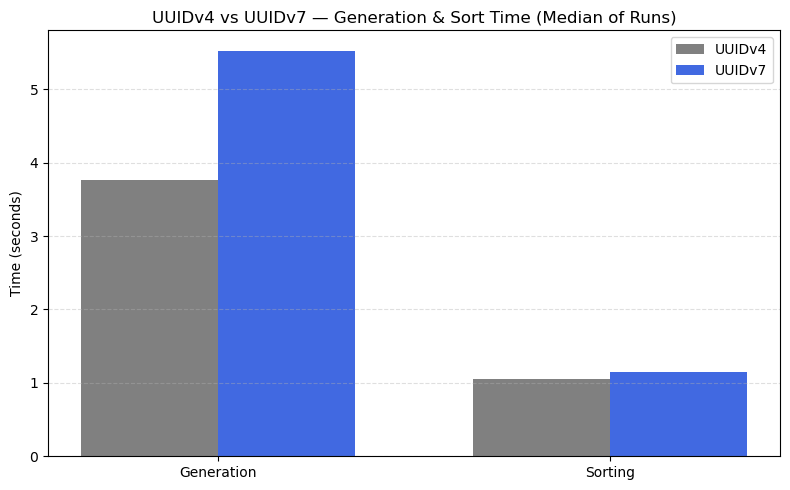

In [22]:
import time
import uuid
import random
import gc
import statistics
import matplotlib.pyplot as plt
from uuid7gen import uuid7  # Make sure uuid7gen.py is in the same folder


def simulate_timestamp_spread(n, spread_ms):
    """
    Generates fake timestamps to simulate equal CPU overhead for both UUID types.
    """
    base_time = time.time()
    return [base_time + random.randint(0, spread_ms) / 1000 for _ in range(n)]


def generate_uuid4_batch(n, spread_ms=100):
    simulate_timestamp_spread(n, spread_ms)
    return [uuid.uuid4() for _ in range(n)]


def generate_uuid7_batch(n, spread_ms=100):
    simulate_timestamp_spread(n, spread_ms)
    return [uuid7() for _ in range(n)]


def benchmark(func, *args, **kwargs):
    """
    Benchmarks a single execution of a function.
    """
    label = kwargs.pop("label", "")
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    duration = end - start
    if label:
        print(f"{label:<35} took {duration:.4f} seconds")
    return result, duration


def median_benchmark(func, *args, runs=5, **kwargs):
    """
    Runs the function multiple times and returns the median duration.
    """
    label = kwargs.get("label", "")
    durations = []

    for i in range(runs):
        gc.collect()
        gc.disable()
        _, dur = benchmark(func, *args, **kwargs)
        gc.enable()
        durations.append(dur)

    median_time = statistics.median(durations)
    print(f"Median of {runs} runs for {label:<20}: {median_time:.4f} sec\n")
    return median_time


def run_benchmark(n=1_000_000, spread_ms=200, runs=5):
    """
    Runs the full benchmark: generation + sorting (no shuffle), returns dictionary of results.
    """
    print(f"\nBenchmarking UUIDv4 vs UUIDv7 with {n:,} IDs (no shuffle)\n")

    random.seed(42)

    # Warmup (helps stabilize CPU performance)
    generate_uuid4_batch(10_000)
    generate_uuid7_batch(10_000)

    # UUIDv4
    gen_time_v4 = median_benchmark(generate_uuid4_batch, n, spread_ms, runs=runs, label="Generate UUIDv4")
    uuid4s = generate_uuid4_batch(n, spread_ms)
    sort_time_v4 = median_benchmark(sorted, uuid4s, key=lambda u: u.bytes, runs=runs, label="Sort UUIDv4 (by bytes)")

    # UUIDv7
    gen_time_v7 = median_benchmark(generate_uuid7_batch, n, spread_ms, runs=runs, label="Generate UUIDv7")
    uuid7s = generate_uuid7_batch(n, spread_ms)
    sort_time_v7 = median_benchmark(sorted, uuid7s, key=lambda u: u.bytes, runs=runs, label="Sort UUIDv7 (by bytes)")

    # Summary
    print("Summary (median of runs):")
    print(f"UUIDv4 - Generate: {gen_time_v4:.3f}s | Sort: {sort_time_v4:.3f}s")
    print(f"UUIDv7 - Generate: {gen_time_v7:.3f}s | Sort: {sort_time_v7:.3f}s")
    print(f"UUIDv7 Generation Speedup: {(gen_time_v4 - gen_time_v7) / gen_time_v4:.1%}")
    print(f"UUIDv7 Sort Speedup:        {(sort_time_v4 - sort_time_v7) / sort_time_v4:.1%}")

    return {
        "Generation": {"UUIDv4": gen_time_v4, "UUIDv7": gen_time_v7},
        "Sorting": {"UUIDv4": sort_time_v4, "UUIDv7": sort_time_v7}
    }


def plot_results(results, save_path=None):
    """
    Plots benchmark results using matplotlib.
    """
    labels = list(results.keys())  # ["Generation", "Sorting"]
    uuid4_times = [results[stage]["UUIDv4"] for stage in labels]
    uuid7_times = [results[stage]["UUIDv7"] for stage in labels]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar([i - width / 2 for i in x], uuid4_times, width, label='UUIDv4', color='gray')
    plt.bar([i + width / 2 for i in x], uuid7_times, width, label='UUIDv7', color='royalblue')

    plt.ylabel("Time (seconds)")
    plt.title("UUIDv4 vs UUIDv7 — Generation & Sort Time (Median of Runs)")
    plt.xticks(ticks=x, labels=labels)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()


if __name__ == "__main__":
    results = run_benchmark(
        n=1_000_000,  # or 10_000_000 if you have memory
        spread_ms=200,
        runs=5
    )
    plot_results(results, save_path="uuid_benchmark_plot.png")



Benchmarking UUIDv4 vs optimized UUIDv7 with 1,000,000 IDs (no shuffle)

Generate UUIDv4                     took 2.6930 seconds
Generate UUIDv4                     took 3.0755 seconds
Generate UUIDv4                     took 2.9397 seconds
Generate UUIDv4                     took 2.8457 seconds
Generate UUIDv4                     took 2.9092 seconds
Median of 5 runs for Generate UUIDv4     : 2.9092 sec
Sort UUIDv4 (by bytes)              took 1.3239 seconds
Sort UUIDv4 (by bytes)              took 1.2519 seconds
Sort UUIDv4 (by bytes)              took 1.4825 seconds
Sort UUIDv4 (by bytes)              took 1.4938 seconds
Sort UUIDv4 (by bytes)              took 1.1667 seconds
Median of 5 runs for Sort UUIDv4 (by bytes): 1.3239 sec
Generate UUIDv7 (batch)             took 3.9620 seconds
Generate UUIDv7 (batch)             took 3.6127 seconds
Generate UUIDv7 (batch)             took 3.7881 seconds
Generate UUIDv7 (batch)             took 3.7344 seconds
Generate UUIDv7 (batch)         

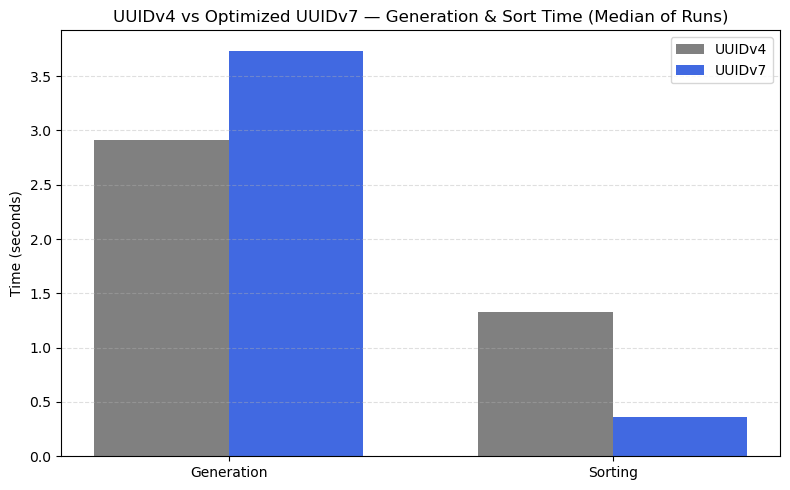

In [4]:
import time
import uuid
import gc
import statistics
from typing import Callable, Dict, List, Optional, Tuple, Any
import matplotlib.pyplot as plt
from uuid7gen import uuid7, batch_uuid7  # Import from your package root


def generate_uuid4_batch(n: int) -> List[uuid.UUID]:
    return [uuid.uuid4() for _ in range(n)]


def generate_uuid7_batch(
    n: int, timestamp_start_ms: Optional[int] = None, interval_ms: int = 1
) -> List[uuid.UUID]:
    return batch_uuid7(n, timestamp_start_ms=timestamp_start_ms, interval_ms=interval_ms)


def benchmark(
    func: Callable[..., Any],
    *args: Any,
    label: str = "",
    **kwargs: Any
) -> Tuple[Any, float]:
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    duration = end - start
    if label:
        print(f"{label:<35} took {duration:.4f} seconds")
    return result, duration


def median_benchmark(
    func: Callable[..., Any],
    *args: Any,
    runs: int = 5,
    label: str = "",
    **kwargs: Any
) -> float:
    durations: List[float] = []
    for _ in range(runs):
        gc.collect()
        gc.disable()
        _, dur = benchmark(func, *args, **kwargs, label=label)
        gc.enable()
        durations.append(dur)
    median_time = statistics.median(durations)
    print(f"Median of {runs} runs for {label:<20}: {median_time:.4f} sec")
    return median_time


def run_benchmark(n: int = 1_000_000, runs: int = 5) -> Dict[str, Dict[str, float]]:
    print(f"\nBenchmarking UUIDv4 vs optimized UUIDv7 with {n:,} IDs (no shuffle)\n")

    # Warmup
    generate_uuid4_batch(10_000)
    generate_uuid7_batch(10_000)

    ts_start = int(time.time() * 1000)

    gen_time_v4 = median_benchmark(generate_uuid4_batch, n, runs=runs, label="Generate UUIDv4")
    uuid4s = generate_uuid4_batch(n)
    sort_time_v4 = median_benchmark(sorted, uuid4s, key=lambda u: u.bytes, runs=runs, label="Sort UUIDv4 (by bytes)")

    gen_time_v7 = median_benchmark(
        generate_uuid7_batch, n, timestamp_start_ms=ts_start, runs=runs, label="Generate UUIDv7 (batch)"
    )
    uuid7s = generate_uuid7_batch(n, timestamp_start_ms=ts_start)
    sort_time_v7 = median_benchmark(sorted, uuid7s, key=lambda u: u.bytes, runs=runs, label="Sort UUIDv7 (by bytes)")

    print("Summary (median of runs):")
    print(f"UUIDv4 - Generate: {gen_time_v4:.3f}s | Sort: {sort_time_v4:.3f}s")
    print(f"UUIDv7 - Generate: {gen_time_v7:.3f}s | Sort: {sort_time_v7:.3f}s")
    print(f"UUIDv7 Generation Speedup: {(gen_time_v4 - gen_time_v7) / gen_time_v4:.1%}")
    print(f"UUIDv7 Sort Speedup:        {(sort_time_v4 - sort_time_v7) / sort_time_v4:.1%}")

    return {
        "Generation": {"UUIDv4": gen_time_v4, "UUIDv7": gen_time_v7},
        "Sorting": {"UUIDv4": sort_time_v4, "UUIDv7": sort_time_v7},
    }


def plot_results(results: Dict[str, Dict[str, float]], save_path: Optional[str] = None) -> None:
    labels = list(results.keys())
    uuid4_times = [results[stage]["UUIDv4"] for stage in labels]
    uuid7_times = [results[stage]["UUIDv7"] for stage in labels]

    x = range(len(labels))
    width = 0.35

    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    plt.bar([i - width / 2 for i in x], uuid4_times, width, label="UUIDv4", color="gray")
    plt.bar([i + width / 2 for i in x], uuid7_times, width, label="UUIDv7", color="royalblue")

    plt.ylabel("Time (seconds)")
    plt.title("UUIDv4 vs Optimized UUIDv7 — Generation & Sort Time (Median of Runs)")
    plt.xticks(ticks=x, labels=labels)
    plt.legend()
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()


if __name__ == "__main__":
    results = run_benchmark(n=1_000_000, runs=5)
    plot_results(results, save_path="uuid7_benchmark_plot.png")
